# Calibração de modelos 2 - Fatores que impactam a calibração

## Introdução

Neste segundo *Notebook* exploramos os métodos discutidos no primeiro *Notebook* da série e avaliamos como modelos de *machine learning* para quiminformática treinados com diferentes representações (descritores 2D e *fingerprints* moleculares) e algoritmos (regressão logística e *Random Forest*) se comportam em relação à calibração. Também vamos explorar o efeito do uso de diferentes estratégies de *splitting* na calibração do modelo: *random split* e *scaffold split*. Para mais detalhes, consulte o Notebook [Data splits - selecionando um conjunto de teste](https://github.com/rflameiro/Python_e_Quiminformatica/blob/main/Quiminformatica/Data%20splits%20-%20selecionando%20um%20conjunto%20de%20teste.ipynb).

## Importar módulos (e mostrar versões)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib
import numpy as np
import pandas as pd
import sklearn

print("Versões")
print("matplotlib:", matplotlib.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)

Versões
matplotlib: 3.8.0
numpy: 1.26.3
pandas: 2.2.0
scikit-learn: 1.4.1.post1


In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.preprocessing import StandardScaler

## Avaliando o efeito das representações, algoritmos e *splitting* na calibração

Vamos usar o conjunto de dados  [BACE (MoleculeNet)](https://moleculenet.org/datasets-1). Selecionei esse conjunto de dados pois os autores já incluíram uma coluna indicando compostos de treinamento e teste separados de acordo com um *scaffold split*, e isso facilitará nossa análise.

Para deixar este *Notebook* mais simples, gerei as representações (descritores 2D e *fingerprints* Morgan) em [outro *Notebook*](https://github.com/rflameiro/Python_e_Quiminformatica/blob/main/Quiminformatica/Criando%20conjuntos%20de%20dados%20de%20descritores%202D%20e%20fingerprints.ipynb), usando o RDKit. Aqui, vamos apenas importar os *dataframes* finais.

In [5]:
# Descritores 2D
df_descs = pd.read_csv("../datasets/bace_descs2D.csv")
df_descs.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,SMILES,Model,Class,pIC50
0,12.864976,-0.193508,12.864976,0.056350,0.592935,431.580,398.316,431.257277,168,0,...,0,0,0,0,0,0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,Train,1,9.154901
1,14.325500,-1.115483,14.325500,0.018908,0.221161,657.823,606.415,657.382204,258,0,...,0,0,0,0,0,0,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,Train,1,8.853872
2,13.784727,-3.529966,13.784727,0.009674,0.247837,591.754,552.442,591.263568,222,0,...,0,0,0,0,0,0,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,Train,1,8.698970
3,14.639226,-4.794456,14.639226,0.021899,0.289042,591.688,552.376,591.251033,224,0,...,0,0,0,0,0,0,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,Train,1,8.698970
4,13.753015,-4.443734,13.753015,0.060530,0.249843,629.725,593.437,629.240388,234,0,...,0,0,0,0,0,0,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,Train,1,8.698970


In [6]:
# Colunas que contêm os valores dos descritores
desc_cols = df_descs.columns[:-4]

In [7]:
# Fingerprints Morgan
df_fps = pd.read_csv("../datasets/bace_fingerprints.csv")
df_fps.head()

,0,1,2,3,4,5,6,7,8,9,...,1018,1019,1020,1021,1022,1023,SMILES,Model,Class,pIC50
0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,Train,1,9.154901
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,Train,1,8.853872
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,Train,1,8.698970
3,0,1,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,Train,1,8.698970
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,Train,1,8.698970


In [8]:
# Colunas que contêm os bits das fingerprints
fps_cols = df_fps.columns[:-4]

### Definir *splits*

Vamos usar os índices dos *dataframes* para criar os *splits*

In [10]:
# Scaffold split 
# Usamos a coluna "Model" - é a mesma nos dois datasets
train_scaffold_idx = df_descs[df_descs["Model"] == "Train"].index
test_scaffold_idx  = df_descs[(df_descs["Model"] == "Valid") | (df_descs["Model"] == "Test")].index

print(len(train_scaffold_idx))
print(len(test_scaffold_idx))

203
1310


In [9]:
# Random split
# Geramos conjuntos de treinamento/teste do mesmo tamanho do scaffold split
np.random.seed(0)

train_random_idx = np.random.choice(range(1513), 203, replace=False)
test_random_idx = np.setdiff1d(np.arange(1513), train_random_idx)

print(len(train_random_idx))
print(len(test_random_idx))

203
1310


### Treinar modelos

Criamos uma função para automatizar o treinamento dos modelos de acordo com as estratégias desejadas e criar o diagrama de confiabilidade.

In [11]:
def output_calibration_display(model, representation, split):

    # Representação
    if representation == "descs":
        df = df_descs
        cols = desc_cols
    elif representation == "fps":
        df = df_fps
        cols = fps_cols

    # Split
    if split == "random":
        X_train = df.loc[train_random_idx, cols]
        y_train = df.loc[train_random_idx, "Class"]
        X_test  = df.loc[test_random_idx, cols]
        y_test  = df.loc[test_random_idx, "Class"]
    elif split == "scaffold":
        X_train = df.loc[train_scaffold_idx, cols]
        y_train = df.loc[train_scaffold_idx, "Class"]
        X_test  = df.loc[test_scaffold_idx, cols]
        y_test  = df.loc[test_scaffold_idx, "Class"]

    # Normalizar valores dos descritores 2D
    if representation == "descs":
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

    # Treinar modelo
    model.fit(X_train, y_train)

    # Criar diagrama de confiabilidade
    y_pred = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
    
    return CalibrationDisplay(prob_true, prob_pred, y_pred)

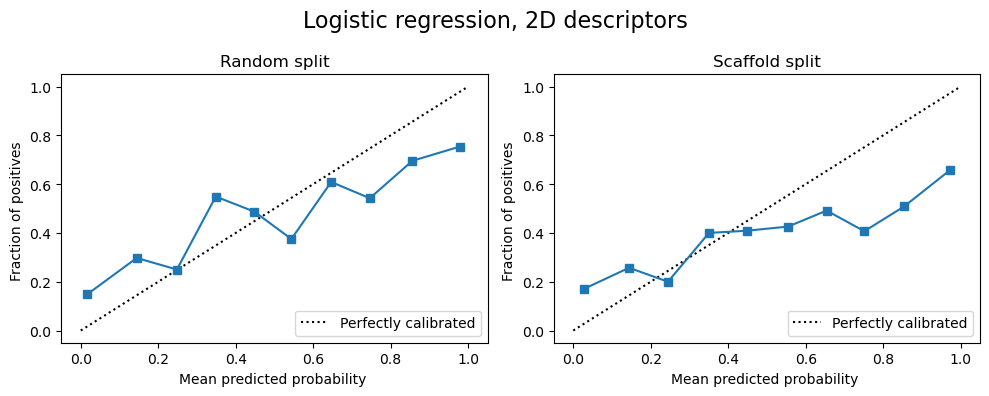

In [12]:
# Logistic regression, 2D descriptors

# Random split
plot1 = output_calibration_display(LogisticRegression(solver='liblinear', random_state=0), "descs", "random")

# Scaffold split
plot2 = output_calibration_display(LogisticRegression(solver='liblinear', random_state=0), "descs", "scaffold")

# Plot CalibrationDisplays lado a lado
fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Logistic regression, 2D descriptors', fontsize=16)

plot1.plot(ax=axs[0])
axs[0].set_title('Random split')

plot2.plot(ax=axs[1])
axs[1].set_title('Scaffold split')

plt.tight_layout()
plt.show()


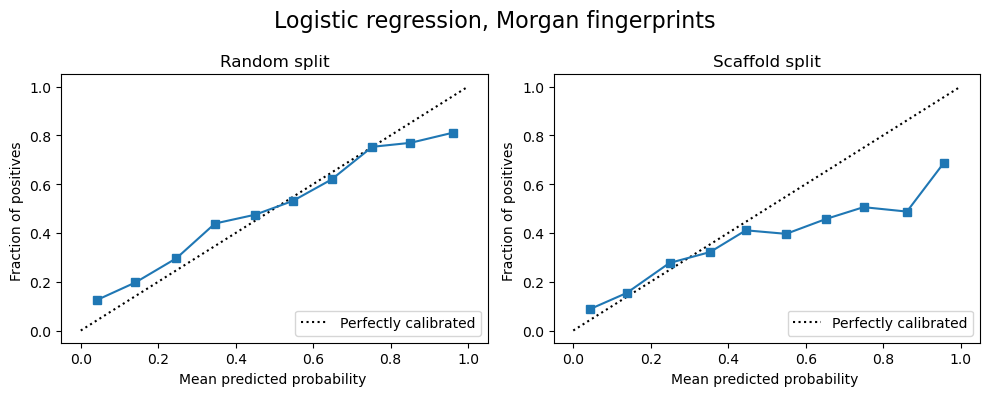

In [13]:
# Logistic regression, Morgan fingerprints

# Random split
plot1 = output_calibration_display(LogisticRegression(random_state=0), "fps", "random")

# Scaffold split
plot2 = output_calibration_display(LogisticRegression(random_state=0), "fps", "scaffold")

# Plot CalibrationDisplays lado a lado
fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Logistic regression, Morgan fingerprints', fontsize=16)

plot1.plot(ax=axs[0])
axs[0].set_title('Random split')

plot2.plot(ax=axs[1])
axs[1].set_title('Scaffold split')

plt.tight_layout()
plt.show()

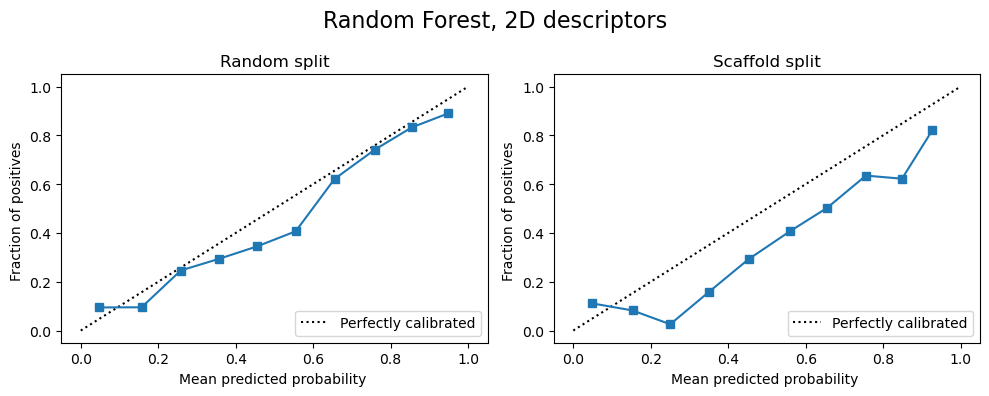

In [14]:
# Random Forest, 2D descriptors

# Random split
plot1 = output_calibration_display(RandomForestClassifier(random_state=0), "descs", "random")

# Scaffold split
plot2 = output_calibration_display(RandomForestClassifier(random_state=0), "descs", "scaffold")

# Plot CalibrationDisplays lado a lado
fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Random Forest, 2D descriptors', fontsize=16)

plot1.plot(ax=axs[0])
axs[0].set_title('Random split')

plot2.plot(ax=axs[1])
axs[1].set_title('Scaffold split')

plt.tight_layout()
plt.show()


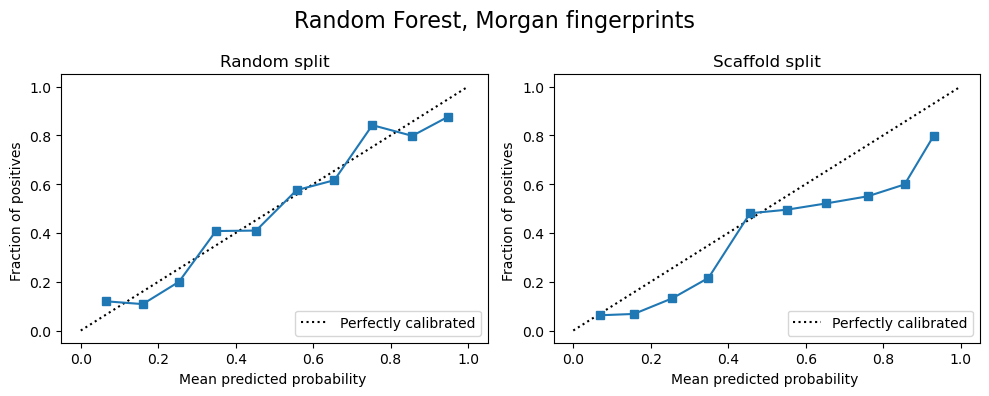

In [15]:
# Random Forest, Morgan fingerprints

# Random split
plot1 = output_calibration_display(RandomForestClassifier(random_state=0), "fps", "random")

# Scaffold split
plot2 = output_calibration_display(RandomForestClassifier(random_state=0), "fps", "scaffold")

# Plot CalibrationDisplays lado a lado
fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Random Forest, Morgan fingerprints', fontsize=16)

plot1.plot(ax=axs[0])
axs[0].set_title('Random split')

plot2.plot(ax=axs[1])
axs[1].set_title('Scaffold split')

plt.tight_layout()
plt.show()


### Interpretação

Esse exemplo foi baseado no trabalho [Real-World Molecular Out-Of-Distribution: Specification and Investigation](https://chemrxiv.org/engage/chemrxiv/article-details/64c012a1b053dad33ae21932), que chamaremos de MOOD.

Os resultados indicam que a combinação *Random forest* + *random split* produz os modelos mais bem calibrados. 

Modelos mais bem calibrados são esperados para o *random split*, que reproduz de forma melhor uma distribuição de dados i.i.d. (independentes e identicamente distribuídos). Note que isso **pode não refletir a realidade**, pois modelos de quiminformática nem sempre são usados apenas para prever propriedades de estruturas similares às do conjunto de treinamento. Dessa forma, o modelo validado com *random split* não necessariamente será bem calibrado para amostras futuras.

Os *fingerprints* Morgan parecem gerar modelos um pouco mais robustos que os descritores 2D para o *scaffold split*, mas isso não é tão claro. No MOOD, foi observado que os descritores 2D e os descritores WHIM (3D) foram os mais robustos e apresentaram melhor capacidade de generalização do que os *fingerprints*. Usamos poucos dados (203 compostos) para treinamento, conforme sugerido pelo MoleculeNet, portanto, é possível que uma melhor calibração seja obtida usando mais dados.

O *scaffold split*, apesar de gerar predições mais adequadas para aplicações reais dos modelos, demonstra que o modelo tem menor confiabilidade. Isso também foi observado no MOOD.

Finalmente, no MOOD foi observado que a calibração tende a degradar para compostos mais distantes do conjunto de treinamento. Dessa forma, é importante definir o domínio de aplicabilidade dos modelos (e remover os compostos fora dele) antes de fazer as curvas de calibração. Pode ser interessante separar o conjunto de teste em dois: compostos mais próximos e os mais distantes, e comparar as duas curvas.

## Calibração com CalibratedClassifierCV()

Vamos ver se é possível melhorar a calibração de um dos nossos modelos. Vou escolher a combinação Morgan *fingerprints* + *Random Forest* + *scaffold split*, pois é usada em diversos trabalhos. O código foi adaptado desse *post* no *blog* [Machine Learning Mastery](https://machinelearningmastery.com/probability-calibration-for-imbalanced-classification/).

In [16]:
from numpy import mean
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Conjunto de treinamento
X_train = df_fps.loc[train_scaffold_idx, fps_cols]
y_train = df_fps.loc[train_scaffold_idx, "Class"]
X_test  = df_fps.loc[test_scaffold_idx, fps_cols]
y_test  = df_fps.loc[test_scaffold_idx, "Class"]

# Definir modelo
model = RandomForestClassifier(random_state=0)

# Definir método de validação cruzada para avaliar o modelo
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=0)

# Avaliar modelo sem calibrar
scores_nocal = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv)

# Definir objeto CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=4)

# Avaliar modelo calibrado
scores_cal = cross_val_score(calibrated, X_train, y_train, scoring='f1', cv=cv)

# Fit 
model.fit(X_train, y_train)
calibrated.fit(X_train, y_train)

# Mostrar resultados
print('Média F1-score modelo original (CV):  %.3f' % mean(scores_nocal))
print('Média F1-score modelo calibrado (CV): %.3f' % mean(scores_cal))
print('F1-score modelo original (teste):     %.3f' % f1_score(y_test, model.predict(X_test))) 
print('F1-score modelo calibrado (teste):    %.3f' % f1_score(y_test, calibrated.predict(X_test)))

Média F1-score modelo original (CV):  0.758
Média F1-score modelo calibrado (CV): 0.781
F1-score modelo original (teste):     0.697
F1-score modelo calibrado (teste):    0.708


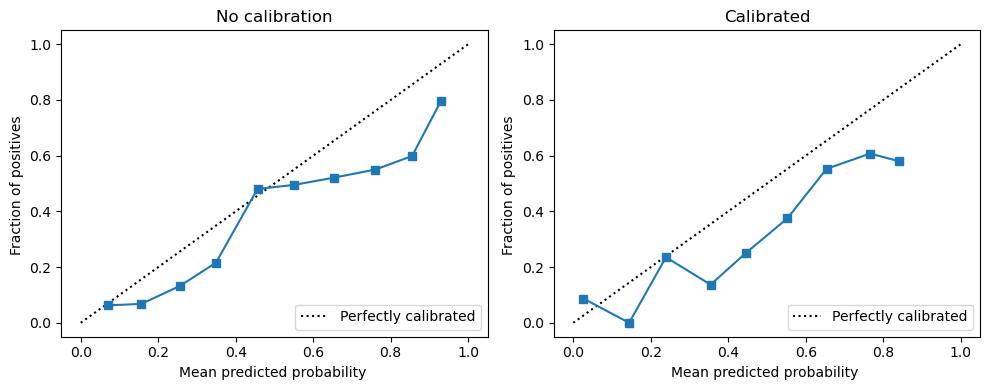

In [17]:
# Criar diagramas de confiabilidade

def calib_plots_compare(model):
    y_pred = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
    
    return CalibrationDisplay(prob_true, prob_pred, y_pred)


plot1 = calib_plots_compare(model)
plot2 = calib_plots_compare(calibrated)

# Plot CalibrationDisplays lado a lado
fig, axs = plt.subplots(1, 2, figsize=(10,4))

plot1.plot(ax=axs[0])
axs[0].set_title('No calibration')

plot2.plot(ax=axs[1])
axs[1].set_title('Calibrated')

plt.tight_layout()
plt.show()

Notamos um pequeno aumento na métrica F1-score com a calibração. O diagrama de confiabilidade, porém, não parece indicar uma significativa melhora na calibração do modelo. 

Conforme já discutimos, é esperado que o *scaffold split* gere modelos menos calibrados, em especial, quando fazemos as predições no conjunto de teste, que pode ser significativamente diferente do conjunto de treinamento.

Vemos que o modelo tende a superestimar as probabilidades (fornece probabilidades mais altas que as reais), indicado visualmente pelo intercepto < 0. A inclinação parece ser aproximadamente igual a 1.

Além da questão do *scaffold split*, temos um conjunto de treinamento pequeno, o que deve levar a um efeito de subajuste (*underfitting*). Vamos diminuir um pouco a complexidade do nosso modelo *Random Forest* (reduzindo `n_estimators` para 50) e avaliar como a calibração muda.

In [18]:
# Mesmo código, apenas modifiquei a variável model com n_estimators=50

# Conjunto de treinamento
X_train = df_fps.loc[train_scaffold_idx, fps_cols]
y_train = df_fps.loc[train_scaffold_idx, "Class"]
X_test  = df_fps.loc[test_scaffold_idx, fps_cols]
y_test  = df_fps.loc[test_scaffold_idx, "Class"]

# Definir modelo
model = RandomForestClassifier(random_state=0, n_estimators=50)

# Definir método de validação cruzada para avaliar o modelo
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=0)

# Avaliar modelo sem calibrar
scores_nocal = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv)

# Definir objeto CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=4)

# Avaliar modelo calibrado
scores_cal = cross_val_score(calibrated, X_train, y_train, scoring='f1', cv=cv)

# Fit 
model.fit(X_train, y_train)
calibrated.fit(X_train, y_train)

# Mostrar resultados
print('Média F1-score modelo original (CV):  %.3f' % mean(scores_nocal))
print('Média F1-score modelo calibrado (CV): %.3f' % mean(scores_cal))
print('F1-score modelo original (teste):     %.3f' % f1_score(y_test, model.predict(X_test))) 
print('F1-score modelo calibrado (teste):    %.3f' % f1_score(y_test, calibrated.predict(X_test)))

Média F1-score modelo original (CV):  0.748
Média F1-score modelo calibrado (CV): 0.787
F1-score modelo original (teste):     0.699
F1-score modelo calibrado (teste):    0.710


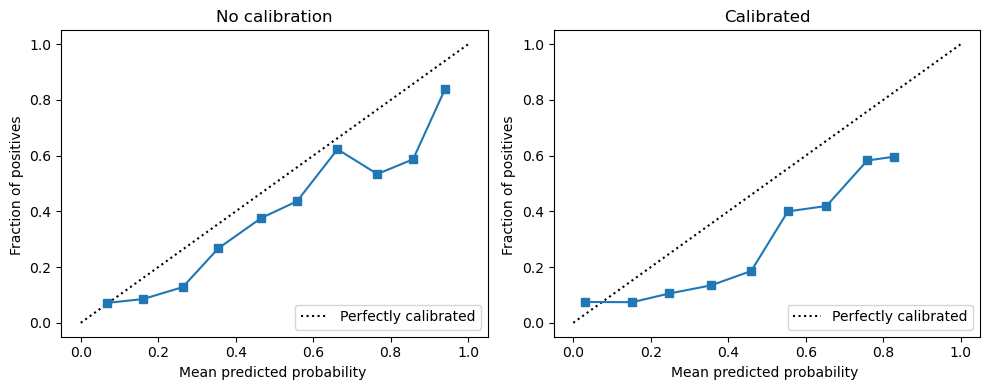

In [19]:
# Criar diagramas de confiabilidade

def calib_plots_compare(model):
    y_pred = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
    
    return CalibrationDisplay(prob_true, prob_pred, y_pred)


plot1 = calib_plots_compare(model)
plot2 = calib_plots_compare(calibrated)

# Plot CalibrationDisplays lado a lado
fig, axs = plt.subplots(1, 2, figsize=(10,4))

plot1.plot(ax=axs[0])
axs[0].set_title('No calibration')

plot2.plot(ax=axs[1])
axs[1].set_title('Calibrated')

plt.tight_layout()
plt.show()

Note que há pouca alteração nas métricas, e que o uso do `CalibratedClassifierCV` parece piorar a calibração do modelo para o conjunto de teste. De fato, o nosso maior problema parece não ser o sobreajuste, mas sim os poucos dados e a maior dificuldade do conjunto de teste devido ao *scaffold split*.

No artigo [JCE](https://www.sciencedirect.com/science/article/abs/pii/S0895435615005818)], os autores comentam (em tradução livre): 

> A estimativa dos coeficientes do modelo foi instável quando os dados de desenvolvimento continham apenas 100 pacientes, apesar de haver mais de 10 eventos por variável... As previsões de risco foram sobreajustadas, conforme evidenciado pela inclinação de calibração e pelas curvas de calibração na validação. Além disso, a intercepção da calibração foi negativa, o que sugere um superestimação geral. Ampliar o conjunto de dados de desenvolvimento aliviou os problemas...

Portanto, se quiséssemos melhorar a calibração do nosso modelo, deveríamos começar buscando mais dados de treinamento.

## Conclusão

Neste *Notebook* avaliamos como diferentes escolhas de modelagem em quiminformática podem afetar a calibração dos nossos modelos. Nossa análise ficou um pouco limitada por usarmos um conjunto de dados relativamente pequeno no contexto do aprendizado de máquina (já para quiminformática, um conjunto de dados 200 estruturas nem sempre é trivial de se obter...). 

Ressaltamos aqui a importância de se avaliar o domínio de aplicabilidade antes de medir a calibração. Devo fazer um *Notebook* sobre esse tema em breve. Com isso, você poderá, por exemplo, separar o conjunto de teste em dois: os compostos mais próximos do conjunto de treinamento, e os mais distantes, e comparar como esses dois grupo se comparam com relação à calibração.